In [1]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [8]:
%%prun # profiling

### load data
# vicsek:
#arrays.npy - normal. arrays2.npy - very few particles. arrays3.npy - high density. arrays4.npy - high density, low noise.
#arrays5.npy - small domain, one clump
#datasets = ['arrays.npy', 'arrays2.npy', 'arrays3.npy']#, 'arrays5.npy']
#datasets = ['data_bu.npy'] # burgers' equation data
## it may be interesting to reintroduce regression on multiple datasets,
## but for now we're just not going to do it

#dataset = 'data_bu.npy'
#dataset = 'data_cbu.npy'
#dataset = 'lamp2.npy'
#dataset = 'lamp2_1e-4.npy'
#dataset = 'lamp_16x.npy'
#dataset = 'lamp_16x_half.npy'
#dataset = 'dump_16h1e4.npy'
#dataset = 'dump_16h1e4g.npy'
#dataset = 'dump_10wide.npy'
#dataset = 'dump_g.npy'
#dataset = 'sim_n1024_1i1.0_2i1.0.npy'
#dataset = 'sim_n1024_1i10^-2.0_2i10^1.0.npy'
#dataset = 'sim_n1024_1i10^2.0_2i10^-1.0.npy'
#dataset = 'sim_n1024_1i10^0.5_2i10^-0.5.npy'
dataset = 'sim_n1024_1i10^0.5_2i10^0.0.npy'
#dataset = 'cuda.npy'
#import scipy.io
#dataset = 'gas_1000_4_0.mat'
#dataset = 'gas_1000_16_4.mat'
#dataset = 'gas_5000_24_4.mat'
#matdata = scipy.io.loadmat(dataset)
#positions = matdata['pos_data']
#vs = matdata['vs_data']
#deltat = matdata['dt'][0][0]
#dims = matdata['dims'][0]
#for i, dset in enumerate(datasets):
positions, vs, deltat, dims = load(dataset, 4)
#pvdd = load(dataset, 1)
#positions = pvdd[0][:, :2, :]
#vs = pvdd[0][:, 2:, :]
#deltat = 0.00030517578125
#dims = [1, vs.shape[-1]]
#positions = positions[0:2, :, :]
#vs = vs[0:2, :, :]
deltat = float(deltat)
#deltat = float(deltat*8) # deltat value wrong because of subsampling
world_size = np.array([dims[0], dims[0], dims[1]])
#world_size = np.array([dims[0], dims[1], dims[2]])
print(world_size)
cg_res = 128#200/256 - lamp; 20 - Jason; 5 - burgers
#world_size[2] += 1 # start at frame 2
#print(positions.shape)
#positions = positions[:, :, 1:]
#vs = vs[:, :, 1:]
#nt = dims[-1]
#positions = positions[:, :, :int(0.4*nt)]
#vs = vs[:, :, :int(0.4*nt)]
#world_size[2] = int(0.4*nt)
#world_size[2] = 50 # restrict to first 50 time steps
data_dict = {}
data_dict['v'] = vs # because scaling can be wrong when outputting directly from LAMMPS
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=0.04, cg_res=cg_res, deltat=deltat, cutoff=6)
#kernel_sigma=0.01/0.04 (lamp),0.1 (Jason?),0.6 (burgers?)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.2#0.2 - LJ (lamp); 1.5 - Jason; 10 - Burgers?; 80 - ?
dom_time = 20 #20 - LJ; 30/50 - Burgers
srd.make_domains(ndomains=20, domain_size=[dom_width, dom_width, dom_time], pad=12)
#srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=10)
#srd.make_domains(ndomains=1, domain_size=[dom_width, dom_width, dom_time], pad=0)
srd.make_weights(m=16, qmax=1) #qmax=1
srd.make_library_matrices(debug=False)

save('Q_bu.npy', srd.dxs, srd.libs)

[  1   1 128]
 

         508790000 function calls (507436044 primitive calls) in 913.813 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  3266780  139.859    0.000  493.773    0.000 _distn_infrastructure.py:1926(cdf)
  3266780   98.233    0.000  691.715    0.000 convolution.py:18(gauss1d)
      200   94.360    0.472  883.887    4.419 process_library_terms.py:199(eval_cgp)
 13271300   61.727    0.000   61.727    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  6533560   49.106    0.000   68.012    0.000 numerictypes.py:575(_can_coerce_all)
33275816/32960461   43.256    0.000  279.989    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
 13143132   37.046    0.000  131.121    0.000 fromnumeric.py:69(_wrapreduction)
  3266780   27.304    0.000   74.515    0.000 _distn_infrastructure.py:997(_open_support_mask)
  3266780   24.986    0.000   24.986    0.000 {method 'outer' of 'numpy.ufunc' objects}
  3567112   23.6

In [9]:
_, libs = load('Q_bu.npy', 2)
libs = libs.item()

In [10]:
import scipy.io
scipy.io.savemat('lammps_Qs.mat', {'Q0': libs[0].Q, 'Q1': libs[1].Q, 'n0': libs[0].col_weights,
                 'n1': libs[1].col_weights})

In [11]:
from identify_models import *
opts = dict()
# manually discourage polynomials
reweight = False
if reweight:
    for i, term in enumerate(libs[0].terms):
        if 'd' in str(term):
            libs[0].col_weights[i] *= 10
        libs[0].col_weights[i] *= 10**(str(term).count('rho')-1)
    for i, term in enumerate(libs[1].terms):
        libs[1].col_weights[i] *= 10**(str(term).count('rho')-1)
        if 'd' in str(term):
            libs[1].col_weights[i] *= 10
opts['threshold'] = "'verbose'"
opts['row_norms'] = libs[0].row_weights
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
opts1['row_norms'] = libs[1].row_weights

#Q = libs[0].Q
#print(Q[:, 3]+Q[:, 14], np.linalg.norm(Q[:, 3]+Q[:, 14]), 
#np.linalg.norm(Q[:, 3]+Q[:, 14])/np.linalg.norm(Q[:, 0]))
#print(np.linalg.norm(Q[:, 0])/libs[0].col_weights[0])
#print(list(zip(libs[1].terms, libs[1].col_weights)))
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2
#excluded_terms=set([libs[0].terms[10], libs[0].terms[16], libs[1].terms[25]]))
# eliminate simple rho^2-type terms immediately

[0.01 s]
Identified model: 1.0 * dj rho[v_j] + 0.9999973488344579 * dt rho = 0 (order 3, residual 1.34e-04)


521.541218255184
521.541218255184
329.0167272961543


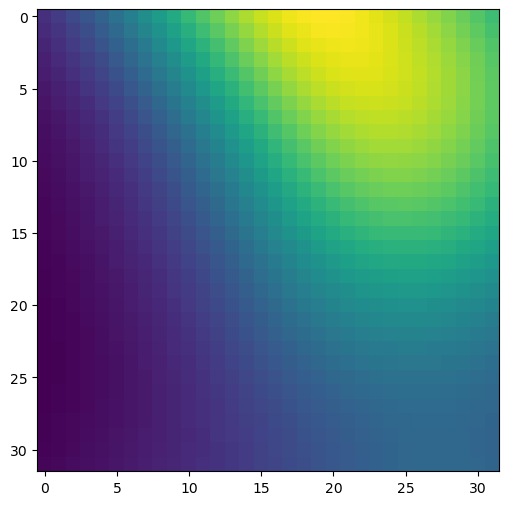

In [7]:
import matplotlib.pyplot as plt
from utils import construct_from_string as cfs
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0, 0, 0]
cgp = srd.cgps[-1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(data))
print(np.mean(np.abs(data)))
print(np.std(data))

708.5852318400704
226.565913131023
0.6698766856813627


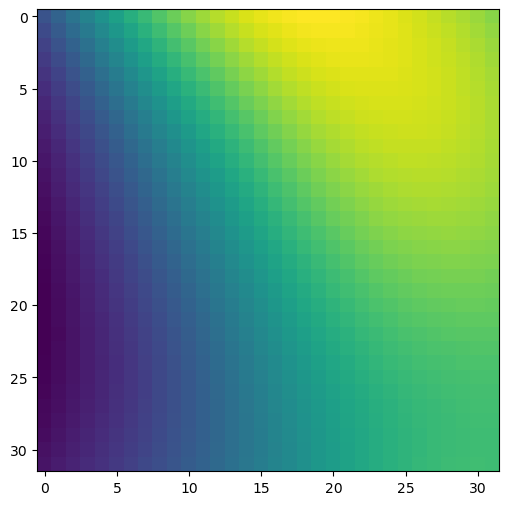

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = [0]
cgp = srd.cgps[1]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))
print(np.std(vs[np.abs(vs)<10]))

931.5940347304988
122.45974378385779


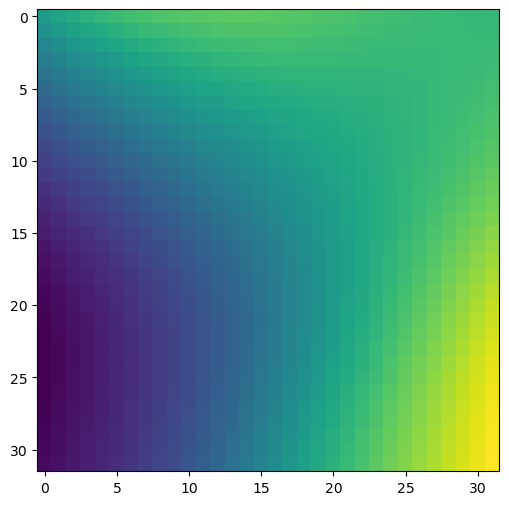

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
domain = srd.domains[0]
obs_dict = {'v': v_obs}
obs_dims = []
cgp = srd.cgps[0]
data = srd.cg_dict[cgp, tuple(obs_dims), domain]
ax.imshow(data[:, :, 0])
print(np.mean(np.abs(data)))
print(np.std(data))

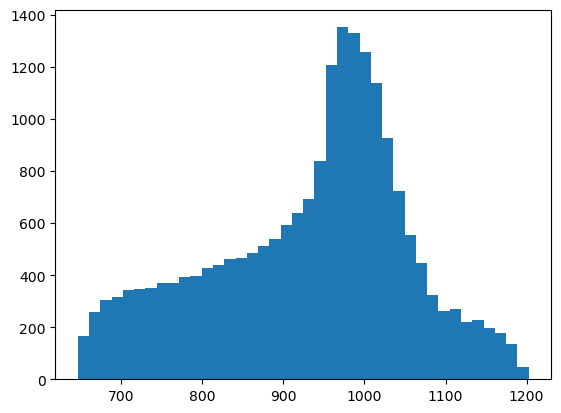

IntegrationDomain([37, 12, 72], [68, 43, 91])


In [10]:
plt.hist(data.flatten(), bins=40)
plt.show()
print(domain)

In [8]:
prts = []
for i in srd.domain_neighbors[domain, domain.times[0]]:
    prts.append(i)
print(np.std(vs[prts, :, domain.times[0]]))

0.20012994338106274


In [1]:
#data = []
#for domain in srd.domains[0]
#obs_dict = {'v': v_obs}
#obs_dims = []
#cgp = srd.cgps[0]
#data = srd.cg_dict[cgp, tuple(obs_dims), domain]
#ax.imshow(data[:, :, 0])

SyntaxError: invalid syntax (2885799474.py, line 2)

In [11]:
print(np.mean(positions[:, 0, :]))

0.2657824533912849


In [9]:
print(np.std(vs))

0.34736777173708616


In [6]:
## mostly not planning to use this code

from ipynb.fs.full.sparse_reg import *
opts = dict()
opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
#opts['threshold'] = "'threshold'"
#opts['n_terms'] = len(terms0)
#opts['gamma'] = 1.2
opts['char_sizes'] = srd.libs[0].col_weights
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[0].Q, opts=opts)
print(srd.libs[0].Q.shape)

(240, 28)


In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[0].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", srd.libs[0].terms[best_term])

[Term 19] 1.0 * rho[v_j] * rho[v_j]
Model residual: 0.0030944418121483697
One-term model residual: 1.294046607514735e-05
Best term (#6): dt^3 rho


In [ ]:
opts['verbose'] = True
opts['char_sizes'] = srd.libs[1].col_weights
opts['avoid'] = []
opts['row_norms'] = None
Xi, lambd, best_term, lambda1 = sparse_reg(srd.libs[1].Q, opts=opts)
print(srd.libs[1].Q.shape)

In [ ]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {srd.libs[1].terms[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", srd.libs[1].terms[best_term])

In [18]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size)

0 1 1
1 rho 1024.0
2 dj^2 rho 521.4619574178486
3 dt rho 521.4619574178486
4 dt dj^2 rho 521.4619574178486
5 dt^2 rho 521.4619574178486
6 dt^3 rho 521.4619574178486
7 rho * rho 1048576.0
8 rho * dj^2 rho 533977.0443958769
9 rho * dt rho 533977.0443958769
10 rho * dt^2 rho 533977.0443958769
11 dj rho[v_j] 336.4123573260973
12 dj^2 dk rho[v_k] 336.4123573260973
13 dt dj rho[v_j] 336.4123573260973
14 dt^2 dj rho[v_j] 336.4123573260973
15 rho * dj rho[v_j] 344486.25390192366
16 rho[v_j * v_j] 426.6708301287641
17 dj^2 rho[v_k * v_k] 217.03073935078223
18 dj dk rho[v_j * v_k] 217.03073935078223
19 dt rho[v_j * v_j] 217.03073935078223
20 dt^2 rho[v_j * v_j] 217.03073935078223
21 rho[v_j] * rho[v_j] 436910.93005185446
22 rho * rho[v_j * v_j] 436910.93005185446
23 rho[v_j] * dt rho[v_j] 222366.00565509702
24 dj rho[v_j * v_k * v_k] 140.01370876364413
0 di rho 521.4619574178486
1 di dj^2 rho 521.4619574178486
2 dt di rho 521.4619574178486
3 dt^2 di rho 521.4619574178486
4 rho * di rho 533977.04

In [16]:
for i in [3, 14, 13, 26, 31, 33, 68, 18, 29]:
    print(libs[1].terms[i-1])

dt di rho
di dj rho[v_j]
rho[v_i]
rho * rho[v_i]
rho * rho * rho[v_i]
rho * rho * rho * rho[v_i]
rho[v_j] * dt rho[v_i * v_j]
dt rho[v_i]
rho * dt rho[v_i]


In [5]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

160 25 (25,)
[Term 3] 1.0 * dt rho. (Char. size: 547.4273695342719)
[Term 11] 0.9999999968280366 * dj rho[v_j]. (Char. size: 353.16350355023144)
Model residual: 5.862770757510146e-09


In [7]:
from scipy.stats.stats import pearsonr 
print(np.vstack([libs[0].Q[1:10, 3],libs[0].Q[1:10, 8]]))
print(libs[0].Q[1:10, 3]+libs[0].Q[1:10, 8])
print(libs[0].Q[0, 0])
print(pearsonr(libs[0].Q[1:10, 3], libs[0].Q[1:10, 8]))
print(np.mean(np.abs(libs[0].Q[:, 3]+libs[0].Q[:, 8])))
print('density:', np.mean(libs[0].Q[:, 1]/libs[0].Q[:, 0]), '+-', 
      np.std(libs[0].Q[:, 1]/libs[0].Q[:, 0])/np.sqrt(30))
print('ratio:', -np.mean(libs[0].Q[:, 3]/libs[0].Q[:, 8]), '+-', 
      np.std(libs[0].Q[:, 3]/libs[0].Q[:, 8])/np.sqrt(30))

[[-6.95568185e+11  4.55270753e+11 -1.83808139e+12  1.94160122e+12
   2.35544109e+12 -2.12889064e+12  1.16166236e+12  5.18281722e+12
   7.36347285e+11]
 [ 1.52431507e+10 -1.57911380e+09 -9.49142219e+09  4.73033219e+10
   4.92454335e+10  3.68346478e+10 -3.50834556e+09 -1.08872950e+11
  -1.44429522e+09]]
[-6.80325034e+11  4.53691640e+11 -1.84757281e+12  1.98890454e+12
  2.40468653e+12 -2.09205599e+12  1.15815402e+12  5.07394427e+12
  7.34902990e+11]
111.10054002700423
(-0.5251251317120536, 0.1465802089361166)
297312982393.39886
density: -3.9269937730131287e+18 +- 6.166616925071817e+18
ratio: 223.42089699173908 +- 442.4693162517066


In [8]:
print(np.linalg.norm(libs[0].Q[:, :], axis=0)/libs[0].col_weights)

[4.96856720e+02 6.10494168e+02 1.18897714e+06 9.97409036e+09
 9.24674997e+03 6.85630153e+07 9.91310056e+05 8.97000730e+09
 2.00042198e+08 5.36010962e+10 1.58236733e+03 5.50660464e+06
 1.39398741e+04 1.74309785e+08 4.20868749e+06 9.04149355e+08
 5.43805546e+03 2.33402302e+07 3.77292775e+04 1.95729242e+07
 2.11752053e+04 1.32054594e+04 9.79190639e+07 1.41577447e+06
 1.28106225e+10 2.85277606e+08 7.63667706e+10 1.96863595e+04
 5.85172115e+06 5.26334865e+04 1.14509626e+03 2.41009354e+06
 1.66260999e+06 5.27261133e+04 2.98347819e+08 2.29200184e+08
 9.98413130e+06 6.78850994e+09 1.18756148e+03 2.27212607e+03
 4.75998082e+06 1.00420082e+07 4.98420253e+06 4.05908869e+06
 9.54709745e+06 2.80538605e+04 3.69235409e+04 5.48841346e+04
 1.72596296e+07 1.32067833e+07 2.68014405e+03 6.52526912e+03
 7.20735021e+04 6.74250593e+06 5.13677323e+04 4.99410417e+04
 4.39061268e+04 3.72241122e+04]


In [12]:
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'di rho[v_j * v_j]']# 'dj^2 rho[v_i]']
#burger_terms = ['rho * rho[v_i]', 'rho[v_i]']
#burger_terms = ['rho[v_i]', 'rho[v_i * v_j * v_j]']
#burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

320 27 (27,)
[Term 0] 0.9149823710604894 * di rho. (Char. size: 266.7199538183941)
[Term 9] 1.0 * dt rho[v_i]. (Char. size: 172.06986460577914)
[Term 17] 0.9221564392474243 * dj rho[v_i * v_j]. (Char. size: 111.00796127765855)
Model residual: 0.1372636049574903


In [14]:
### not fixed (obviously)
#veqconst_terms = ['1', 'v_j * v_j']
veqconst_terms = ['rho', 'rho * v_j * v_j']
col_numbers = [find_term(terms0, name) for name in veqconst_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 16] -0.004286563115825593 * rho. (Char. size: 0.1464261231728444)
[Term 28] 1.0 * rho * v_j * v_j. (Char. size: 0.0005121399208783936)
Model residual: 0.0005697337514007149


In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho

In [144]:
### (1, 1) - col size norm, long trajectory, larger domains, sigma=0.04 ###
[0.01 s]
Identified model: 0.9999941767033532 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 9.91e-08)
[0.12 s]
Identified model: 1.0 * dt rho + -0.0019393012307609143 * rho * dt rho + 9.351022221012353e-07 * rho * rho * dt rho = 0 (order 5, residual 2.63e-06)
[0.24 s]
Identified model: 1.0 * 1 + -0.0009916867285711317 * rho + 1.1697095194982046e-06 * rho * rho[v_j * v_j] + -0.00117931738281563 * rho[v_j * v_j] = 0 (order 5, residual 1.44e-05)
[0.36 s]
Identified model: 1.0 * dj^2 rho + -0.46760700423159485 * dt^2 rho + -0.0009632186103852298 * rho * dj^2 rho + 0.00045384794082332236 * rho * dt^2 rho = 0 (order 5, residual 2.70e-05)
[0.60 s]
Identified model: 1.0 * di rho + -0.0019257584194597244 * rho * di rho + 9.238594430200825e-07 * rho * rho * di rho = 0 (order 5, residual 2.27e-06)
[0.60 s]
Identified model: 1.0 * dt^2 rho + -0.001935212535739339 * rho * dt^2 rho + 9.290322822931163e-07 * rho * rho * dt^2 rho = 0 (order 6, residual 5.65e-06)
[1.18 s]
Identified model: 1.0 * 1 + -0.0012907457494940621 * rho + 2.855577751197353e-13 * rho * rho * rho * rho = 0 (order 6, residual 8.56e-06)
[1.70 s]
Identified model: 1.0 * dt dj^2 rho + -0.22515238860762746 * dt^3 rho + -0.0009599756835766671 * rho * dt dj^2 rho + 0.00021603618213135008 * rho * dt^3 rho = 0 (order 6, residual 2.04e-05)
[2.22 s]
Identified model: 1.0 * dt rho[v_j * v_j] + 0.0005155153703625918 * dt^3 rho + -0.0009685487841685498 * rho * dt rho[v_j * v_j] + -4.939861238044323e-07 * rho * dt^3 rho = 0 (order 6, residual 3.79e-05)
[2.67 s]
Identified model: 1.0 * dt rho + -0.32875738821901135 * dt rho[v_j * v_j] + -0.0009547248510533903 * rho * dt rho + 0.00031922445963196937 * rho * dt rho[v_j * v_j] = 0 (order 6, residual 3.05e-05)
[4.12 s]
Identified model: 1.0 * dt di rho + -0.0019356351920459833 * rho * dt di rho + 9.329988764183588e-07 * rho * rho * dt di rho = 0 (order 6, residual 1.79e-06)
[8.06 s]
Identified model: 1.0 * dt rho[v_i] + -0.0019280208944151233 * rho * dt rho[v_i] + 9.251916968812042e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 2.79e-06)
[11.81 s]
Identified model: 1.8196598972472693e-09 * rho * rho * rho * rho[v_i] + -2.824835613618127e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 4.71e-06)
[15.31 s]
Identified model: 1.0 * di rho + 0.37610159292712514 * dj rho[v_i * v_j] + 0.3933421416870819 * dt rho[v_i] + -0.0009813596765878676 * rho * di rho + -0.00036626024192678794 * rho * dj rho[v_i * v_j] + -0.0003857345839495145 * rho * dt rho[v_i] = 0 (order 6, residual 1.34e-05)
[18.70 s]
Identified model: 6.924968913187393e-07 * rho * rho * rho[v_i] + -0.0009744242046365395 * rho * rho[v_i * v_j * v_j] + 1.0 * rho[v_i * v_j * v_j] + -0.739382581026262 * rho[v_i] = 0 (order 6, residual 1.37e-05)
[21.98 s]
Identified model: 1.0 * di dj^2 rho + -0.3817391735900403 * dt^2 di rho + -0.000995404392102315 * rho * di dj^2 rho + 0.00037691444729516017 * rho * dt^2 di rho = 0 (order 6, residual 3.58e-05)

SyntaxError: invalid syntax (3756173767.py, line 1)

In [ ]:
### sigma = 0.01 ###
[0.02 s]
Identified model: 0.9999999959627874 * dj rho[v_j] + 1.0 * dt rho = 0 (order 3, residual 6.34e-12)
[1.35 s]
Identified model: 1.0 * di rho + -0.0018633277640221532 * rho * di rho + 7.002008258355073e-07 * rho * rho * di rho = 0 (order 5, residual 4.90e-05)
[2.58 s]
Identified model: -0.9666862875871163 * rho[v_i] * rho[v_j * v_j] + 1.0 * rho[v_j] * rho[v_i * v_j] = 0 (order 5, residual 7.85e-05)
[2.00 s]
Identified model: 3.9293130942914495e-07 * rho * rho * rho[v_j * v_j] + -0.0013749461512638003 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 2.39e-05)
[3.89 s]
Identified model: -0.0006114367940185144 * rho * rho[v_j * v_j] + 4.417065809582353e-07 * rho * rho[v_j] * rho[v_j] + 1.0 * rho[v_j * v_j] + -0.0008597016181151673 * rho[v_j] * rho[v_j] = 0 (order 6, residual 4.10e-05)
[5.63 s]
Identified model: 1.0 * 1 + -2.756684842649201e-07 * dj^2 rho + 6.255878773278568e-10 * rho * dj^2 rho + -1.7314136727527456e-13 * rho * rho * dj^2 rho = 0 (order 6, residual 3.79e-05)
[7.41 s]
Identified model: -0.00012408079785366727 * dt^2 rho + 2.4118467865909007e-07 * rho * dt^2 rho + -8.85167280410579e-11 * rho * rho * dt^2 rho + -0.0007071048985563922 * rho * rho[v_j * v_j] + 1.0 * rho[v_j * v_j] = 0 (order 6, residual 3.46e-05)
[9.14 s]
Identified model: 4.1105500057476617e-10 * rho * rho * rho * rho[v_i] + -1.2071852387395117e-06 * rho * rho * rho[v_i] + 1.0 * rho[v_i] = 0 (order 6, residual 3.62e-05)
[17.92 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + 4.959952200079346e-07 * rho[v_i] * rho[v_j] * rho[v_j] + -0.0015942484232388517 * rho[v_j] * rho[v_i * v_j] = 0 (order 6, residual 6.14e-05)
[26.20 s]
Identified model: 0.6415296986083273 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + -0.00048261110036053247 * rho * dj rho[v_i * v_j] + -0.0012608752996658289 * rho * dt rho[v_i] + 3.2533737106148037e-07 * rho * rho * dt rho[v_i] = 0 (order 6, residual 4.06e-05)

In [ ]:
### (3, 0.3)
0.998 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] + 1.10e-05 * di rho^2 = 0
### (3, 1)
Identified model: 0.993633815171316 * dt dj rho[v_i * v_j] + 1.0 * dt^2 rho[v_i] + -0.0004986445654309399 * rho * dt^2 rho[v_i] + -0.0005185104934969214 * rho[v_i] * dt dj rho[v_j] = 0 (order 6, residual 3.45e-05)